# 浣熊與袋鼠辨識模型

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
!pip install keras==2.2.4

In [3]:
from google.colab import drive
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd '/content/gdrive/My Drive'

# 下載yolov3程式碼
import os
if not os.path.exists("keras-yolo3") :
  !git clone https://github.com/qqwweee/keras-yolo3
else :
  print("keras-yolo3 exists")

%cd keras-yolo3
!ls

/content/gdrive/My Drive
Cloning into 'keras-yolo3'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 151.07 KiB | 1.24 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/gdrive/My Drive/keras-yolo3
coco_annotation.py  kmeans.py	train_bottleneck.py  yolo.py
convert.py	    LICENSE	train.py	     yolov3.cfg
darknet53.cfg	    model_data	voc_annotation.py    yolov3-tiny.cfg
font		    README.md	yolo3		     yolo_video.py


In [5]:
# model_data/yolo.h5 模型 & 權重
# 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  
  # 把權重轉換為 keras 能夠讀取的格式(.h5)
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model doesn't exist, downloading...
Converting yolov3.weights to yolo.h5...


In [6]:
# 下載 raccoon 與 kangaroo 的資料集
if not os.path.exists("raccoon_dataset"):
  !git clone https://github.com/experiencor/raccoon_dataset.git 
else:
  print("raccoon_dataset exists")

if not os.path.exists("kangaroo"):
  !git clone https://github.com/experiencor/kangaroo.git
else:
  print("kangaroo exists")

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 20.66 MiB/s, done.
Resolving deltas: 100% (412/412), done.
Checking out files: 100% (419/419), done.
Cloning into 'kangaroo'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 18.39 MiB | 17.87 MiB/s, done.
Resolving deltas: 100% (158/158), done.
Checking out files: 100% (329/329), done.


In [7]:
import numpy as np
# 訓練模型時需使用的 annotation 檔名, 若已經做好轉換, 則不會每次再重新跑這段轉換的程式碼
if not os.path.exists("train_labels.txt"):
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  
  sets=['train', 'val']

  # "raccoon", "kangaroo" 的資料類別
  classes = ["raccoon", "kangaroo"]

  # 把 annotation(.xml) 轉換到訓練時需要的資料形態
  def convert_annotation(image_id, list_file):
      in_file = open('annotation_xml/%s.xml'%(image_id))
      tree=ET.parse(in_file)
      root = tree.getroot()

      for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1: 
              continue
          cls_id = classes.index(cls)  # class index
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), 
                int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

  # 把 raccoon_dataset/images 與 kangaroo/images 檔案合併後, 當成訓練集 & 驗證集資料
  for root,dirs,files in os.walk('raccoon_dataset/images') :
    print('raccoon jpg 檔數量:', len(files))
  for root_2,dirs_2,files_2 in os.walk('kangaroo/images') :
    print('kangaroo jpg 檔數量:', len(files_2))
  # 把 files_2 合併在 files list 內
  files.extend(files_2)
  print('所有 jpg 檔數量:', len(files))
    
  jpg_ids = ''.join(files).strip().split('.jpg')[:-1]
  # 70% 檔案資料當成訓練集資料
  train_index = np.random.choice(jpg_ids, size=int(len(jpg_ids)*0.7), replace=False)
  val_index = np.setdiff1d(jpg_ids, train_index)

  !mkdir train val
  # 把訓練集資料檔索引, 放入 train 資料夾
  train_txt = open('train/train.txt', 'w')
  print("save train index at train/train.txt")       
  for train_id in train_index : 
      train_txt.write('%s' %(train_id))
      train_txt.write('\n')
  train_txt.close()

  # 把驗證集資料檔索引, 放入 val 資料夾
  val_txt = open('val/val.txt', 'w')
  print("save val index at val/val.txt")       
  for val_id in val_index : 
      val_txt.write('%s' %(val_id))
      val_txt.write('\n')
  val_txt.close()

  # 把annotation(.xml), 放入 annotation_xml 資料夾
  !mkdir annotation_xml
  !cp raccoon_dataset/annotations/*.xml ./annotation_xml
  !cp kangaroo/annots/*.xml ./annotation_xml

  # 把類別資料放入 class.txt
  class_txt = open('class.txt', 'w')
  print("save class at class.txt")       
  for class_id in classes : 
      class_txt.write('%s' %(class_id))
      class_txt.write('\n')
  class_txt.close()

  for image_set in sets:
      image_ids = open('%s/%s.txt'%(image_set, image_set)).read().strip().split()
      
      annotation_path = '%s_labels.txt'%(image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)
      # 處理訓練集 & 驗證集資料檔
      for image_id in image_ids:
        if 'raccoon' in image_id :
          list_file.write('./raccoon_dataset/images/%s.jpg' %(image_id))
        else :
          list_file.write('./kangaroo/images/%s.jpg' %(image_id))  
        convert_annotation(image_id, list_file)
        list_file.write('\n')
      list_file.close()

raccoon jpg 檔數量: 200
kangaroo jpg 檔數量: 164
所有 jpg 檔數量: 364
save train index at train/train.txt
save val index at val/val.txt
save class at class.txt
save annotation at train_labels.txt
save annotation at val_labels.txt


In [8]:
# convert.py '-w' : 代表只轉換權重 weights 到 model_data/yolo_weights.h5
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Converting pretrained YOLOv3 weights for training


In [9]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [10]:
annotation_path_train = 'train_labels.txt' # 轉換好格式的 train 標註檔案
annotation_path_val = 'val_labels.txt' # 轉換好格式的 val 標註檔案
log_dir = 'logs/final/' # 訓練好的模型儲存的路徑
classes_path = 'class.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416)

is_tiny_version = len(anchors)==6 
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5')

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

with open(annotation_path_train) as f:
    lines_train = f.readlines()
with open(annotation_path_val) as f:
    lines_val = f.readlines()
np.random.seed(13900)
np.random.shuffle(lines_train)
np.random.shuffle(lines_val)
np.random.seed(None)
num_train = len(lines_train)  
num_val = len(lines_val)      

if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 32
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model_1= model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint, reduce_lr])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')














Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 254 samples, val on 110 samples, with batch size 32.




Epoch 1/50
7/7 [==============================] - 30s 4s/step - loss: 4541.6357 - val_loss: 2470.3992

Epoch 2/50
7/7 [==============================] - 22s 3s/step - loss: 1817.9291 - val_loss: 1052.7383
Epoch 3/50
7/7 [==============================] - 20s 3s/step - loss: 836.3132 - val_loss: 551.7432
Epoch 4/50
7/7 [==============================] - 20s 3s/step - loss: 468.6457 - val_loss: 335.4675
Epoch 5/50
7/7 [==============================] - 19s 3s/step - loss: 306.0039 - val_loss: 226.7761
Epoch 6/50
7/7 [==============================] - 20s 3s/step - loss: 226.2623 - val_loss: 194.7199
Epoch 7/50
7/7 [==============================] - 19s 3s/step - loss: 189.1482 - val_loss: 157.1403
Epoch 8/50
7/7 [===========================

ResourceExhaustedError: ignored

In [11]:
if True:
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    hist_model= model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    
    model.save_weights(log_dir + 'trained_weights_final.h5')

Unfreeze all of the layers.
Train on 254 samples, val on 110 samples, with batch size 16.
Epoch 51/100
15/15 [==============================] - 36s 2s/step - loss: 22.6337 - val_loss: 21.8867
Epoch 52/100
15/15 [==============================] - 20s 1s/step - loss: 18.7672 - val_loss: 19.5183
Epoch 53/100
15/15 [==============================] - 23s 2s/step - loss: 17.3148 - val_loss: 17.9247
Epoch 54/100
15/15 [==============================] - 23s 2s/step - loss: 16.5489 - val_loss: 18.2409
Epoch 55/100
15/15 [==============================] - 23s 2s/step - loss: 16.0563 - val_loss: 15.7547
Epoch 56/100
15/15 [==============================] - 23s 2s/step - loss: 15.5899 - val_loss: 17.3473
Epoch 57/100
15/15 [==============================] - 23s 2s/step - loss: 16.2364 - val_loss: 16.5905
Epoch 58/100
15/15 [==============================] - 22s 1s/step - loss: 15.4814 - val_loss: 16.2311

Epoch 00058: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 59/100


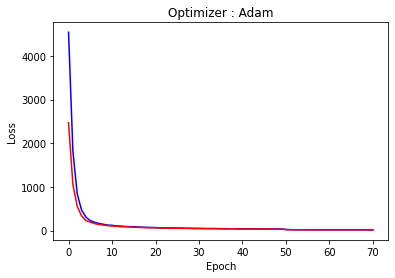

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
model_1.history['loss'] + hist_model.history['loss']

plt.title('Optimizer : Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_1.history['loss'] + hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(model_1.history['val_loss'] + hist_model.history['val_loss'], color='r', label='Validation Loss')

In [15]:
from yolo import YOLO
import numpy as np
import time
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

classes_path = 'class.txt'
log_dir = 'logs/final/' # 訓練好的模型儲存的路徑

yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

def detect_video(yolo, video_path, output_path=""):
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'MP4V')
    video_fps       = vid.get(cv2.CAP_PROP_FPS) 
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    isOutput = True if output_path != "" else False
    if isOutput:
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    video_cnt = 0  
    video_playtime = []  
    while True:
        return_value, frame = vid.read()
        video_cnt += 1 
        if return_value == True : 
            image = Image.fromarray(frame)
            start_time = time.time() 
            image = yolo.detect_image(image)
            end_time = time.time()
            time_img = end_time - start_time  
            video_playtime.append(round(time_img, 3)) 
            result = np.asarray(image)
            cv2.putText(result, text='fps', org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.50, color=(255, 0, 0), thickness=2)
            if isOutput:
                out.write(result)
        else :  
            break
    vid.release() 
    out.release()  
    return video_playtime, video_cnt 

# 偵測 Raccoon.mp4
video_playtime, video_cnt = detect_video(yolo_model, video_path="Raccoon.mp4", output_path="Raccoon_final.mp4")

# Kangaroo 平均 fps :
avg_fps = 1/np.mean(video_playtime)
print("Raccoon.mp4 avg fps: %.3f" % avg_fps)

Streaming output truncated to the last 5000 lines.
Found 1 boxes for img
raccoon 0.93 (0, 35) (1280, 643)
0.04646716299976106
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (0, 37) (1280, 645)
0.047108167999795114
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (0, 38) (1280, 644)
0.04636989299979177
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (0, 39) (1280, 641)
0.045959676999700605
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (0, 45) (1280, 638)
0.04563962499923946
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (0, 45) (1280, 637)
0.04891661900001054
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 43) (1280, 637)
0.04767870900013804
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (8, 42) (1280, 640)
0.04709055200055445
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (23, 46) (1280, 635)
0.046813532999294694
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (12, 46) (1280, 633)
0.04975520100015274
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (16, 41) (1280, 637